In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/LightGCN_PyTorch/code

/content/drive/MyDrive/github/LightGCN_PyTorch/code


In [ ]:
# load pretrained embeddings by LigthGCN model
path = '/content/drive/MyDrive/github/LightGCN_PyTorch/code/embeddings'
user_emb_file = os.path.join(path, "user_embeddings.npy")
item_emb_file = os.path.join(path, "item_embeddings.npy")
user_embeddings = np.load(user_emb_file)
item_embeddings = np.load(item_emb_file)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model

# Define the generator
def build_generator(latent_dim, output_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_shape, activation='tanh'))
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

# Define the discriminator
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(512, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=input_shape)
    validity = model(img)

    return Model(img, validity)

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return gan

In [ ]:
# Build the generator and discriminator
latent_dim = user_embeddings.shape[1]
output_shape = item_embeddings.shape[1]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(input_shape=(output_shape,))

# Build the GAN model
gan = build_gan(generator, discriminator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8320      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [ ]:
d_loss_list=[]
g_loss_list=[]


In [ ]:
# hyper-parameters
latent_dim = 64 #50
reg_lambda = 0.01
epochs = 100
batch_size = 64
learning_rate = 0.001 #0.001

In [ ]:
# Train the GAN model


for epoch in range(epochs):
    # Select a random batch of user embeddings
    idx = np.random.randint(0, user_embeddings.shape[0], batch_size)
    user_batch = user_embeddings[idx]

    # Generate fake item embeddings
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    item_batch = generator.predict(noise)

    # Compile the discriminator model
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy")

    # Train the discriminator on real and fake data
    discriminator_loss_real = discriminator.train_on_batch(item_embeddings, np.ones((item_embeddings.shape[0], 1)))
    discriminator_loss_fake = discriminator.train_on_batch(item_batch, np.zeros((batch_size, 1)))
    # Compute the average discriminator loss for the minibatch
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

    # Train the generator
    gan_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Sample a minibatch of m noise samples from the prior distribution
    num_items = 100
    noise = np.random.normal(0, 1, (num_items, latent_dim))
    # Train the generator to fool the discriminator
    g_loss = gan.train_on_batch(noise, np.ones((num_items, 1)))
    d_loss_list.append(discriminator_loss)
    g_loss_list.append(g_loss)
    # Print the progress
    if epoch % 10 == 0:
      print("Epoch {}/{} Discriminator loss: {:.4f} Generator loss: {:.4f}".format(epoch+1, epochs, discriminator_loss, gan_loss))



2/2 [==============================] - 3s 6ms/step
Epoch 1/100 Discriminator loss: 0.6923 Generator loss: 0.7709
2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 6ms/step
Epoch 11/100 Discriminator loss: 0.7340 Generator loss: 0.6646
2/2 [==============================] - 0s 6ms/step
Epoch 21/100 Discriminator loss: 0.7896 Generator loss: 0.5622
2/2 [==============================] - 0s 5ms/step
Epoch 31/100 Discriminator loss: 0.8468 Generator loss: 0.4892
2/2 [==============================] - 0s 7ms/step
Epoch 41/100 Discriminator loss: 0.8764 Generator loss: 0.4472
2/2 [==============================] - 0s 4ms/step
Epoch 51/100 Discriminator loss: 0.9219 Generator loss: 0.3954
2/2 [==============================] - 0s 4ms/step
Epoch 61/100 Discriminator loss: 0.9567 Generator loss: 0.3781
2/2 [==============================] - 0s 8ms/step
Epoch 71/100 Discriminator loss: 0.9832 Generator loss: 0.3508
2/2 [==============================] - 0s 5ms/step
Epoch 81/100 Discriminator loss: 0.9997 Generator loss: 0.3298
2/2 [==============================] - 0s 5ms/step
Epoch 91/100 Discriminator loss: 1.02

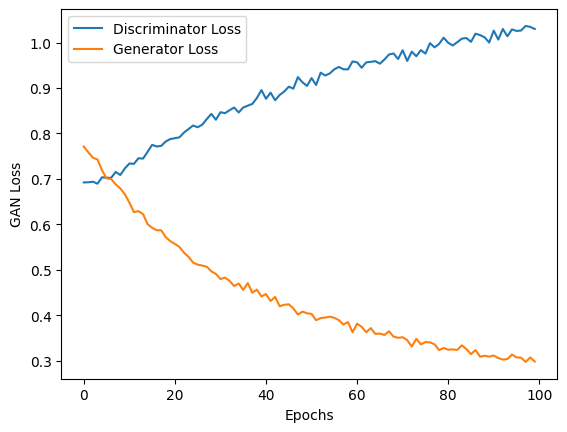

In [ ]:
# plot the loss of GAN model
plt.plot(d_loss_list,label="Discriminator Loss")
plt.plot(g_loss_list,label='Generator Loss')
plt.xlabel("Epochs")
plt.ylabel("GAN Loss")
plt.legend()
plt.show()

In [ ]:
# save trained Gan model
gan.save('/content/drive/MyDrive/github/LightGCN_PyTorch/code/embeddings/gan.h5')